In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.cross_validation import train_test_split
from scipy.stats.stats import pearsonr
from itertools import combinations_with_replacement

from collections import defaultdict

In [2]:
#import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

## Looking at our data

In [3]:
final = pd.read_csv('../data/final_review.csv',index_col=0)
final.head()

,anime,anime_name,name,age,sex,reviews,overall,animation,character,sound,story,Trains,BoardingHouse,Political,Demons,BasedonaLightNovel,Supernatural,Comedy,BountyHunters,Harem,EmotionalAbuse,Androids,Robots,Mecha,Western,Ninja,Thriller,Adventure,LoveTriangle,Magic,RPG,Violence,Shinigami,Military,Sports,Parody,TimeTravel,Aliens,JapaneseMythology,ReverseHarem,Cyberpunk,Swordplay,ClassicalMusic,Detectives,FeudalJapan,Romance,Terrorism,Tournaments,MagicalGirl,PantyShots,...,BasedonaVideoGame,Mercenaries,PersoninaStrangeWorld,FoodandBeverage,Vampires,Cyborgs,Incest,Shoujo-ai,MMORPG,LGBTThemes,noitaminA,Abstract,SuddenGirlfriendAppearance,Monster-of-the-week,Mystery,OriginalWork,Police,WorkLife,PsychicPowers,Maids,PlayorDie,Chibi,Dystopia,Psychological,HandtoHandCombat,Crude,Angels,SliceofLife,BasedonaVisualNovel,ExplicitSex,Shorts,Survival,OuterSpace,CGAnimation,Master-ServantRelationship,ExplicitViolence,Assassins,MatureThemes,Josei,MartialArts,America,BasedonanOtomeGame,Gunfights,Samurai,ComingofAge,AnimalAbuse,Fantasy,PhysicalAbuse,SchoolLife,Ecchi
0,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,SogiitaGunhaGUTS,15.00000,M,Well it's a short animation to celebrate Kamac...,10,10,10,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,dokkoida,Dokkoida?!,angelsreviews,26.00000,F,NaN,5,5,6,5,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,inazuma-eleven,Inazuma Eleven,xxjacobxx3,25.00000,M,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,9,9,9,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,inazuma-eleven,Inazuma Eleven,Lumineux,25.23511,F,Story: 6,7,8,6,8,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,brigadoon-marin-to-melan,Brigadoon Marin to Melan,roriconfan,34.00000,M,NaN,8,8,8,9,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are six main components to the dataframe, with each row corresponding to a review.  They are:

* `anime`: both *anime* and *anime_name* reference the title of the anime being reviewed
* `name`: the user id who made the review
* `age/sex`: information about the user
* `reviews`: text review of the anime
* `ratings`: numerical reviews of the anime; five categories: *overall*, *animation*, *character*, *sound*, and *story*; these are rated out of 10
* `categories`: indicator variables for each category

### Missing Data

Working with missing data is a topic of lengthy discussion in the fields of data science, statistics, research, and frankly any field that works with information of any type.  While there is no universally accepted best method of dealing with missing data, here we have implemented one of the most common - replacing the missing entries with the mean of the values from that feature's column.

In [4]:
# fill empty ratings with the average
ratings = ['animation','character','overall','sound','story']
for i in ratings:
    mean = final[i].mean()
    final[i].fillna(mean,inplace=True)

In [5]:
# in case of repeats
final=final.drop_duplicates(['anime','name'])
final.shape

(17194, 141)

### Baseline Predictions

User review counts mean and median 3.85342895563 1.0


(0, 25)

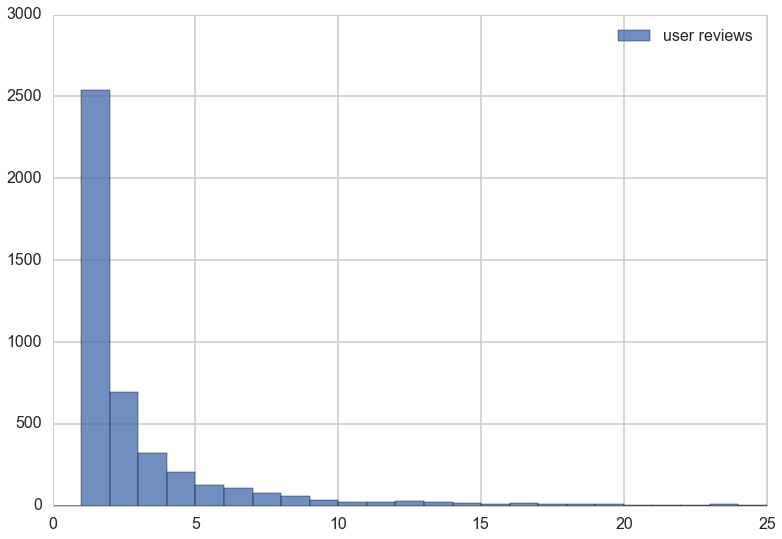

In [36]:
c=final.groupby('name').anime.count()
print "User review counts mean and median",np.mean(c), np.median(c)
plt.hist(c, bins=np.arange(50), alpha=0.8, label="user reviews");
plt.legend();
plt.xlim([0,25])

In [189]:
trainlist=[]
testlist=[]
validatelist=[]
take=2
for k, v in final.groupby('name'):
    if len(v) > 2:
        takenos=np.random.choice(range(take), size=take/2, replace=False)
        takelist=np.array([e in takenos for e in range(take)])
        validatelist.append(v[-take:][~takelist])#use those 
        testlist.append(v[-take:][takelist])#use the other 
        trainlist.append(v[:-take])
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(14748, 142) (1223, 142) (1223, 142)


In [190]:
train = traindf.append(validatedf[~validatedf.anime.isin(traindf.anime)]).append(testdf[~testdf.anime.isin(traindf.anime)])
validate = validatedf[validatedf.anime.isin(traindf.anime)]
test = testdf[testdf.anime.isin(traindf.anime)]

In [78]:
maskval=[e in set(validate.anime).difference(set(train.anime)) for e in validate.anime] 
masktest=[e in set(test.anime).difference(set(train.anime)) for e in test.anime] 
print np.sum(maskval), np.sum(masktest)

0 0


In [192]:
# mapping of userid and anime
uuids=train.name.unique()#unique-user-ids
uiids=train.anime.unique()#unique-item-ids

uuidmap={v:k for k,v in enumerate(uuids)}#of length U
uiidmap={v:k for k,v in enumerate(uiids)}#of length M

In [99]:
# append user_avg to final df
m = final[['name','overall']].groupby('name').mean()
m_dict = m.to_dict()['overall']
final['user_avg'] = final.name.map(m_dict)

In [100]:
train_ybar = train.overall.mean()

# calculating biases for user, anime, sex, and age
biases = {}
for cat in ['name', 'anime', 'sex', 'age']:
    # calculate means
    m = train[[cat,'overall']].groupby(cat).mean()
        
    biases[cat] = (m - train_ybar).to_dict()['overall']

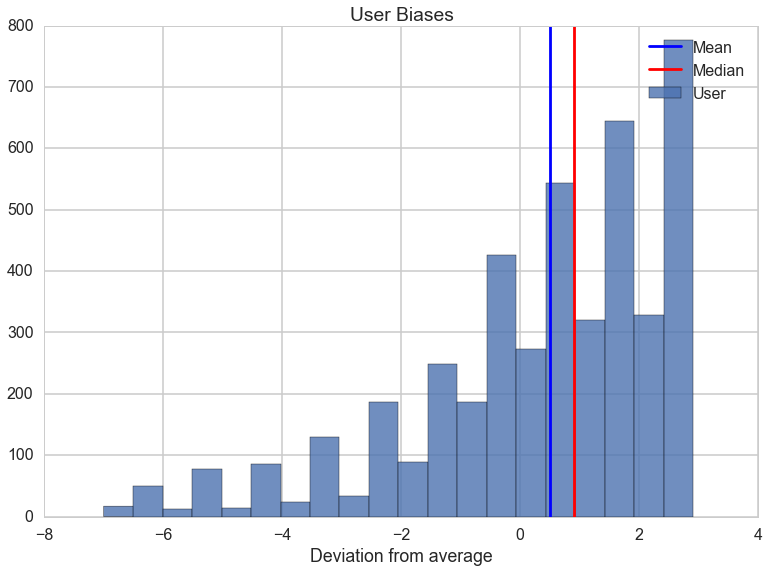

In [81]:
hist1 = plt.hist(biases['name'].values(),alpha=0.8,bins=20,label='User')
plt.title('User Biases')
plt.xlabel("Deviation from average")
plt.axvline(x=np.mean(biases['name'].values()), label='Mean')
plt.axvline(x=np.median(biases['name'].values()), color='r', label='Median')
plt.legend()

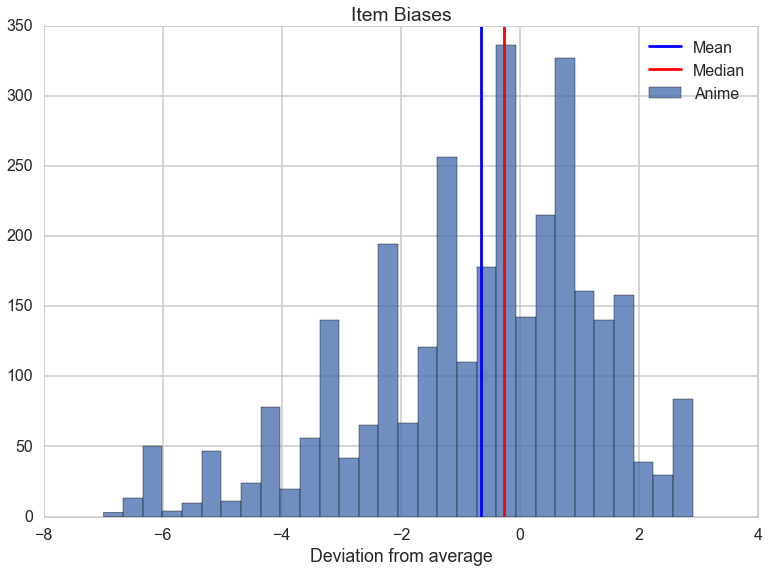

In [82]:
hist2 = plt.hist(biases['anime'].values(),bins=30,alpha=0.8,label='Anime')
plt.title('Item Biases')
plt.xlabel("Deviation from average")
plt.axvline(x=np.mean(biases['anime'].values()), label='Mean')
plt.axvline(x=np.median(biases['anime'].values()), color='r', label='Median')
plt.legend()

The shapes of the two graphs are definitely interesting.  First of all, there are clear peaks at each integer, since users have a tendency to make their ratings whole numbers, even though they were allowed to make them decimals (halves were also not uncommon, such as 5.5, 6.5, etc.).  Secondly, so many users tended to have a positive bias - it's very possible that people will only go through the effort of rating an anime if they particularly enjoyed it, something that's also reflected in the mean rating being around 7-7.5.

In [83]:
predictions={}
predictions_valid={}

In [85]:
# test set
test_ubias = [biases['name'][user] for user in test.name]
test_ibias = [biases['anime'][anime] for anime in test.anime]
predictions["baseline"] = [train_ybar + u + i for u, i in zip(test_ubias, test_ibias)]

In [87]:
# validate set
val_ubias = [biases['name'][user] for user in validate.name]
val_ibias = [biases['anime'][anime] for anime in validate.anime]
predictions_valid["baseline"] = [train_ybar + u + i for u, i in zip(val_ubias, val_ibias)]

In [236]:
def get_rmse(s, s_predict):
    diff = np.subtract(np.ma.masked_array(s, np.isnan(s)),np.ma.masked_array(s_predict), np.isnan(s_predict))
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [89]:
def compare_results(stars_actual, stars_predicted, ylow=0, yhigh=10, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1, label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,10],[0,10], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0, 10])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

RMSE for baseline 2.40911645988


/Users/tiffanylee/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


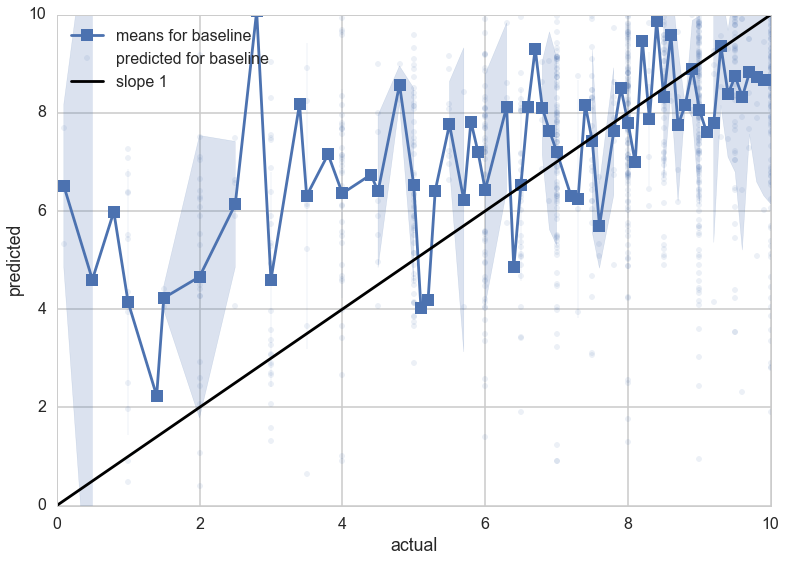

In [90]:
compare_results(test.overall.tolist(),predictions['baseline'], model="baseline", predicteds=True);

### Using kNN

In [91]:
#for each restaurant get the unique userids who rated it
users_for_anime = train.groupby('anime')['name'].unique()
anime=uiids
lres=len(anime)
supports=[[[] for i in range(lres)] for i in range(lres)]
supporthistlist=[]
for i,an1 in enumerate(anime):
    for j,an2 in enumerate(anime):
        if  i <= j:#its symmetric
            if an1==an2:
                common_reviewers=users_for_anime[an1]
            else:
                common_reviewers = set(users_for_anime[an1]).intersection(set(users_for_anime[an2]))
                supporthistlist.append(len(common_reviewers))
            supports[i][j]=common_reviewers
            supports[j][i]=common_reviewers
print "Mean and Median support is:",np.mean(supporthistlist), np.median(supporthistlist)

Mean and Median support is: 0.104041686179 0.0


In [104]:
"""
Given a subframe or dictionary of anime 1 reviews and a subframe or dictionary of anime 2 reviews, 
and the number of common reviewers n_common,
where the reviewers are those who have reviewed both anime, return 
the pearson correlation coefficient between the user average subtracted ratings.
The case for zero common reviewers is handled separately, return 0. If the correlation is
NaN if any of the individual variances are 0 (the n=1 case), return 0 instead.
"""
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    r1 = rest1_reviews['overall'] - rest1_reviews['user_avg']
    r2 = rest2_reviews['overall'] - rest2_reviews['user_avg']
    rho = pearsonr(r1, r2)[0]
    if np.isnan(rho):
        rho = 0
    return rho

In [93]:
def get_anime_reviews(anime, df, set_of_users):
    """
    given a anime and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.name.isin(set_of_users)) & (df.anime==anime)
    reviews = df[mask]
    reviews = reviews[reviews.name.duplicated()==False]
    return reviews

In [94]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, rindexmap, supports):
        "the constructor, takes a map of animes to integers"
        database={}
        self.rindexmap=rindexmap
        self.supports=supports
        l_keys=len(self.rindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two animes"
        sim=self.database_sim[self.rindexmap[b1]][self.rindexmap[b2]]
        nsup=self.database_sup[self.rindexmap[b1]][self.rindexmap[b2]]
        return (sim, nsup)

In [95]:
db=Database(uiidmap, supports)

In [152]:
def mapper1(row):
    return row[3], (row[1], row[7], row[-1])

def combiner(items):
    indict={}
    for key, value in items:
        if not indict.has_key(key):
            indict[key]=[]
        indict[key].append(value)
    return indict.items()

def reducer1(the_input):
    name, values = the_input
    ratings=[]
    for anime,overall,user_avg in values:
        ratings.append((anime,(overall, user_avg)))
    return name, ratings

from itertools import combinations_with_replacement

def mapper2(itemstuple):
    combs = combinations_with_replacement(itemstuple[1],2)
    return [((c[0][0],c[1][0]), (c[0][1],c[1][1])) for c in combs]

def combiner_list(itemslist):
    indict={}
    for items in itemslist:
        for key, value in items:
            if not indict.has_key(key):
                indict[key]=[]
            indict[key].append(value)
    return indict.items()

def reducer2(the_input):
    common_ratings = the_input[1]
    n_common = len(common_ratings)
    r1_stars = []
    r1_avg = []
    r2_stars = []
    r2_avg = []
    for rating in common_ratings:
        r1_stars.append(rating[0][0])
        r1_avg.append(rating[0][1])
        r2_stars.append(rating[1][0])
        r2_avg.append(rating[1][1])
    r1_dict = {'overall':np.array(r1_stars),'user_avg':np.array(r1_avg)}
    r2_dict = {'overall':np.array(r2_stars),'user_avg':np.array(r2_avg)}
    rho = pearson_sim(r1_dict,r2_dict,n_common)
    return the_input[0], (rho, n_common)

def map_reduce(tuples):
    mapped1=map(mapper1, tuples)
    combine1=combiner(mapped1)
    reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])
    mapped2=map(mapper2,reduced1)
    combine2=combiner_list(mapped2)
    output=reduce(lambda x,y: x + [reducer2(y)], combine2, [])
    return output

In [153]:
%%time
tuples=train.itertuples()
sims=map_reduce(tuples)

CPU times: user 58min 30s, sys: 3min 7s, total: 1h 1min 37s
Wall time: 1h 15min 3s


In [157]:
def populate_from_mr(db, df, mapredlist):
    for tpair,vpair in mapredlist:
        i1=db.rindexmap[tpair[0]]
        i2=db.rindexmap[tpair[1]]
        db.database_sim[i1][i2]=vpair[0]
        db.database_sup[i1][i2]=vpair[1]
        db.database_sim[i2][i1]=vpair[0]
        db.database_sup[i2][i1]=vpair[1]

In [158]:
populate_from_mr(db, train, sims)

In [164]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

In [163]:
"""
Function
--------
knearest

Parameters
----------
anime : string
    The name of the anime whose nearest neighbors we want
set_of_animes : array
    The set of animes from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two animes. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
A sorted list
    of the top k similar animes. The list is a list of tuples
    (anime, shrunken <strong>distance</strong>, common support).
"""

from operator import itemgetter
def knearest(anime, set_of_animes, dbase, k=7, reg=3.):
    """
    Given a anime, dataframe, and database, get a sorted list of the
    k most similar animes from the set of anime.
    """
    similars=[]
    for other_anime in set_of_animes:
        if other_anime!=anime:
            sim, nc=dbase.get(anime, other_anime)
            ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=(1. - ssim)/2.
            similars.append((other_anime, simdist, nc ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

In [162]:
def get_users_animes(df, user_id):
    dfuser=df[df.name==user_id]
    dfuserdedup=dfuser.drop_duplicates('anime')
    return dict(zip(dfuserdedup.anime.values, dfuserdedup.overall.values))

In [229]:
"""
Function
--------
rating

Parameters
----------
set_of_anime: Dictionary
    The dictionary of animes: overall-rating pairs you want to make the prediction from.
    This would be the output of a function like get_users_animes
train_map: Dictionary
    A dictionary with keys mean, users and items which have estimates of
    overall average or intercept, user coefficients(averages), and
    item coefficients(averages) respectively
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
anime : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A float
    which is the imputed rating that we predict that user_id will make for anime_id
    
Notes
--------
If the sum of scores is 0, return the baseline estimate of the ranking.
"""
def rating(set_of_animes, biases, dbase, anime, name, age, sex, k=7, reg=3.):
    sims = knearest(anime, set_of_animes.keys(), dbase, k, reg)
    
    if len(sims) == 0:
        return float('nan')
    
    base = biases['mean'] + biases['name'][name] + biases['anime'][anime] + biases['age'][age] + biases['sex'][sex]
    
    d = zip(*sims)[1]
    d = len(d) - sum(d)
    
    predict = 0
    
    # denominator cannot be zero
    if d != 0:
        for sim in sims:
            # base for neighbor restaurant
            base_j = biases['mean'] + biases['name'][name] + biases['anime'][sim[0]] + biases['age'][age] + biases['sex'][sex]
            predict += (1 - sim[1]) * (set_of_animes[sim[0]] - base_j)
        predict /= d
    
    return (base + predict)

In [168]:
biases['mean'] = train_ybar

In [209]:
trainuser=train.name.tolist()[0]
testrest=test[test.name==trainuser].anime.values[0]
testage=test[test.name==trainuser].age.values[0]
testsex=test[test.name==trainuser].sex.values[0]

print trainuser, testrest

def get_actual(df, userid, bizid):
    return df[(df.name==userid) & (df.anime==bizid)]['overall'].values[0]

print "Actual", get_actual(test, trainuser, testrest)
print "Predicted",rating(get_users_animes(train, trainuser), biases, db, testrest, trainuser, testage, testsex, k=2, reg=3.)

00081 martian-successor-nadesico
Actual 3.0
Predicted 9.37083333333


In [228]:
def get_ratings_user_nbd(indf, traindf, train_map, db, k=2, reg=3.):
    zips=zip(indf.anime, indf.name, indf.overall,indf.age,indf.sex)
    preds=[]
    actuals=[]
    for (r,u,actual,a,s) in zips:
        pred=rating(get_users_animes(traindf, u),train_map, db, r,u,a,s, k, reg)
        preds.append(pred)
        actuals.append(actual)
    return np.array(preds), np.array(actuals)

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('bool') with casting rule 'same_kind'

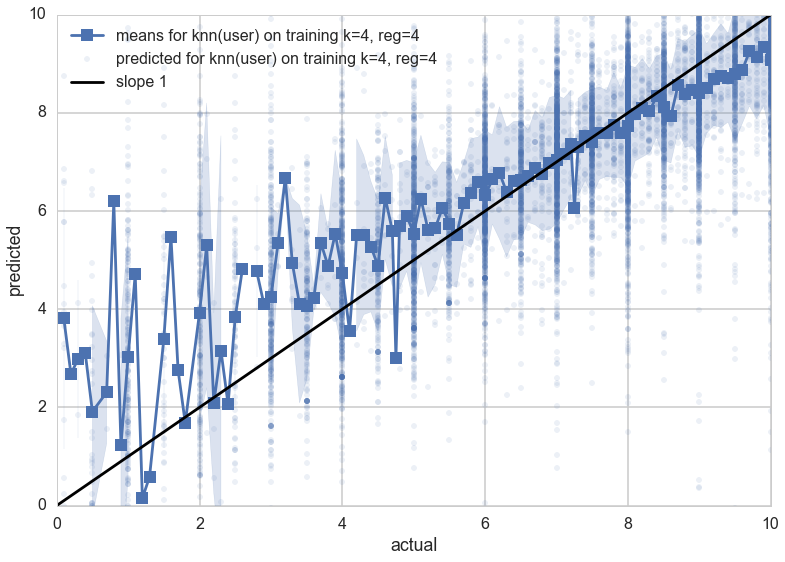

In [237]:
pt, at = get_ratings_user_nbd(train, train, biases, db, k=4, reg=4.)
compare_results(at,pt, model="knn(user) on training k=4, reg=4", predicteds=True)

In [232]:
rmsedict = dict()
for k in np.arange(1,101,10):
    for reg in np.arange(1,101,10):
        pt, at = get_ratings_user_nbd(validate, validate, biases, db, k=k, reg=reg)
        rmsedict[(k,reg)] = get_rmse(pt,at)

KeyboardInterrupt: 

In [ ]:
mintup=min(rmsedict, key=rmsedict.get)
mintup

In [ ]:
for k in np.arange(mintup[0]-10,mintup[0]+10,5):
    for reg in np.arange(mintup[1]-10,mintup[1]+10,5):
        pt, at = get_ratings_user_nbd(validatedf, validatedf, train_avgs, db, k=k, reg=reg)
        rmsedict[(k,reg)] = get_rmse(pt,at)

In [ ]:
mintup=min(rmsedict, key=rmsedict.get)
mintup

In [ ]:
predictions['knn'],at = get_ratings_user_nbd(traindf, traindf, train_avgs, db, k=mintup[0], reg=float(mintup[1]))
predictions_valid['knn'],v_at = get_ratings_user_nbd(validatedf, validatedf, train_avgs, db, k=mintup[0], reg=float(mintup[1]))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

compare_results(at,predictions['knn'], model="knn(user) on optimized k and reg", predicteds=True, onsame=ax)
compare_results(testdf.stars,predictions['baseline'], model="baseline", predicteds=True, onsame=ax)